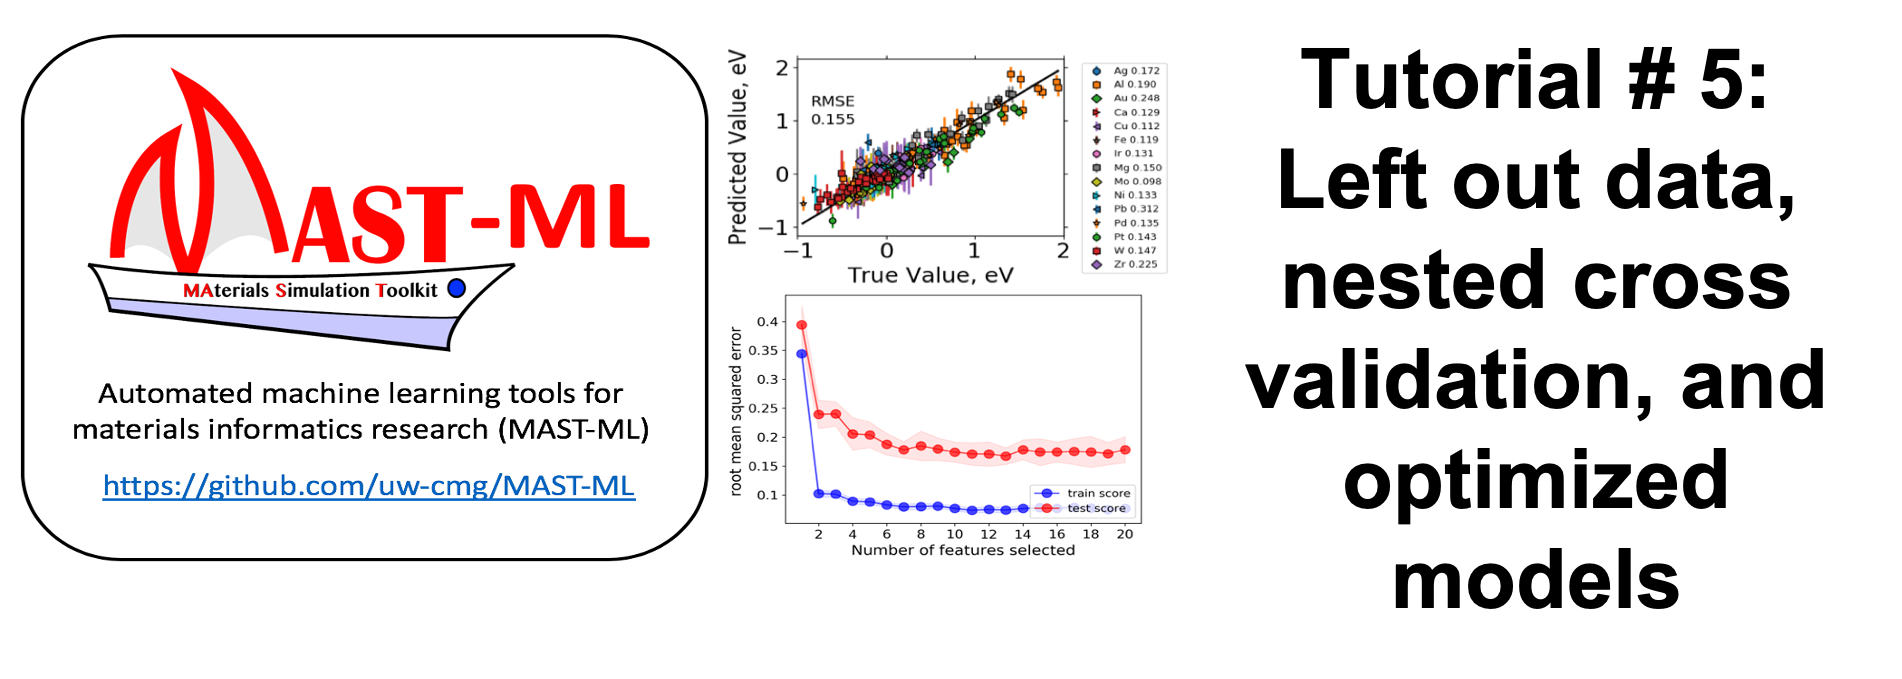

# Welcome to the fifth MAST-ML tutorial notebook, 

# Left out data, nested cross valiation, and optimized models with MAST-ML! 

## In this notebook, we will perform more advanced model fitting routines, including nested cross validation and hyperparameter optimization. In this tutorial, we will learn how to use MAST-ML to:

1. [Set up MAST-ML on Colab and begin session](#task1)
2. [Assess performance on manually left-out test data](#task2)
3. [Perform nested cross validation to assess model performance on unseen data](#task3)
4. [Optimize the hyperparameters of our models to create the best model](#task4)


## Task 1: Set up MAST-ML on Colab and begin session <a name="task1"></a>

If you are working on Google Colab and need to install MAST-ML, 
begin by pip installing MAST-ML to the Colab session
and install the needed dependencies:

In [1]:
!pip install mastml

     |████████████████████████████████| 122kB 8.8MB/s 
     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 5.8MB 10.9MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
     |████████████████████████████████| 3.0MB 49.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 215kB 56.7MB/s 
     |████████████████████████████████| 13.2MB 40.8MB/s 
     |████████████████████████████████| 829kB 45.3MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 296kB 54.3MB/s 
  

Sync your Google drive to Colab so that we can save MAST-ML results to our Google
Drive. If we save to the Colab session, the data will be deleted when the session 
ends.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we import the MAST-ML modules used in this tutorial

In [2]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.models import SklearnModel
from mastml.preprocessing import SklearnPreprocessor
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.hyper_opt import GridSearch, RandomizedSearch, BayesianSearch
import numpy as np
import mastml
import os
data_path = os.path.join(mastml.__path__._path[0], 'data')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git
forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git


Here, we set the name of the savepath to save MAST-ML results to, and initialize
our MAST-ML run

When the above command is run, a new folder with the name designated SAVEPATH is created.
This is where all of the output for the current MAST-ML run will be saved to.
Note that you can perform multiple runs with the same folder name, and the current datetime
will be appended to the name so that no data is lost or overwritten.

In [3]:
SAVEPATH = 'drive/MyDrive/MASTML_tutorial_5_NestedCV_and_OptimizedModels'

mastml = Mastml(savepath=SAVEPATH)
savepath = mastml.get_savepath

## Task 2: Assess performance on manually left-out test data <a name="task2"></a>

In this tutorial, we will see there are two ways to evaluate models in
a "two-level" fashion, i.e. where we split data into train/leftout data, 
then build and evaluate models with a cross validation data splitter on
the training set to build various sub train/test splits. This is also
commonly called nested cross validation. The leftout data is never used 
in training at any point, so can function as a good approximation for
how the model may perform on new, unseen data.

MAST-ML offers two methods to do this. The first is for the user to specify 
specific data points in the imported data that should be reserved as left-out
data. The second method is to perform an automatic nested cross-validation scheme.
Here, we will showcase the first method where some data points are manually
selected to function as left-out data.

In this tutorial, we will again use the diffusion dataset that we examined in the 
previous tutorials. Here, we use the LocalDatasets module to load in the diffusion dataset. 
We are using the diffusion_data_leaveoutPt.xlsx file as it contains a column denoting
the data to leave out (those with Pt as the host element)

To specify which data points are left out, we made a new column in the data file (it can
have whatever name you want), and then label 0 if the data is not left out data and 1
if the data is to be used as left-out data. For this example we are using all data where
Pt is the host element as left out data.

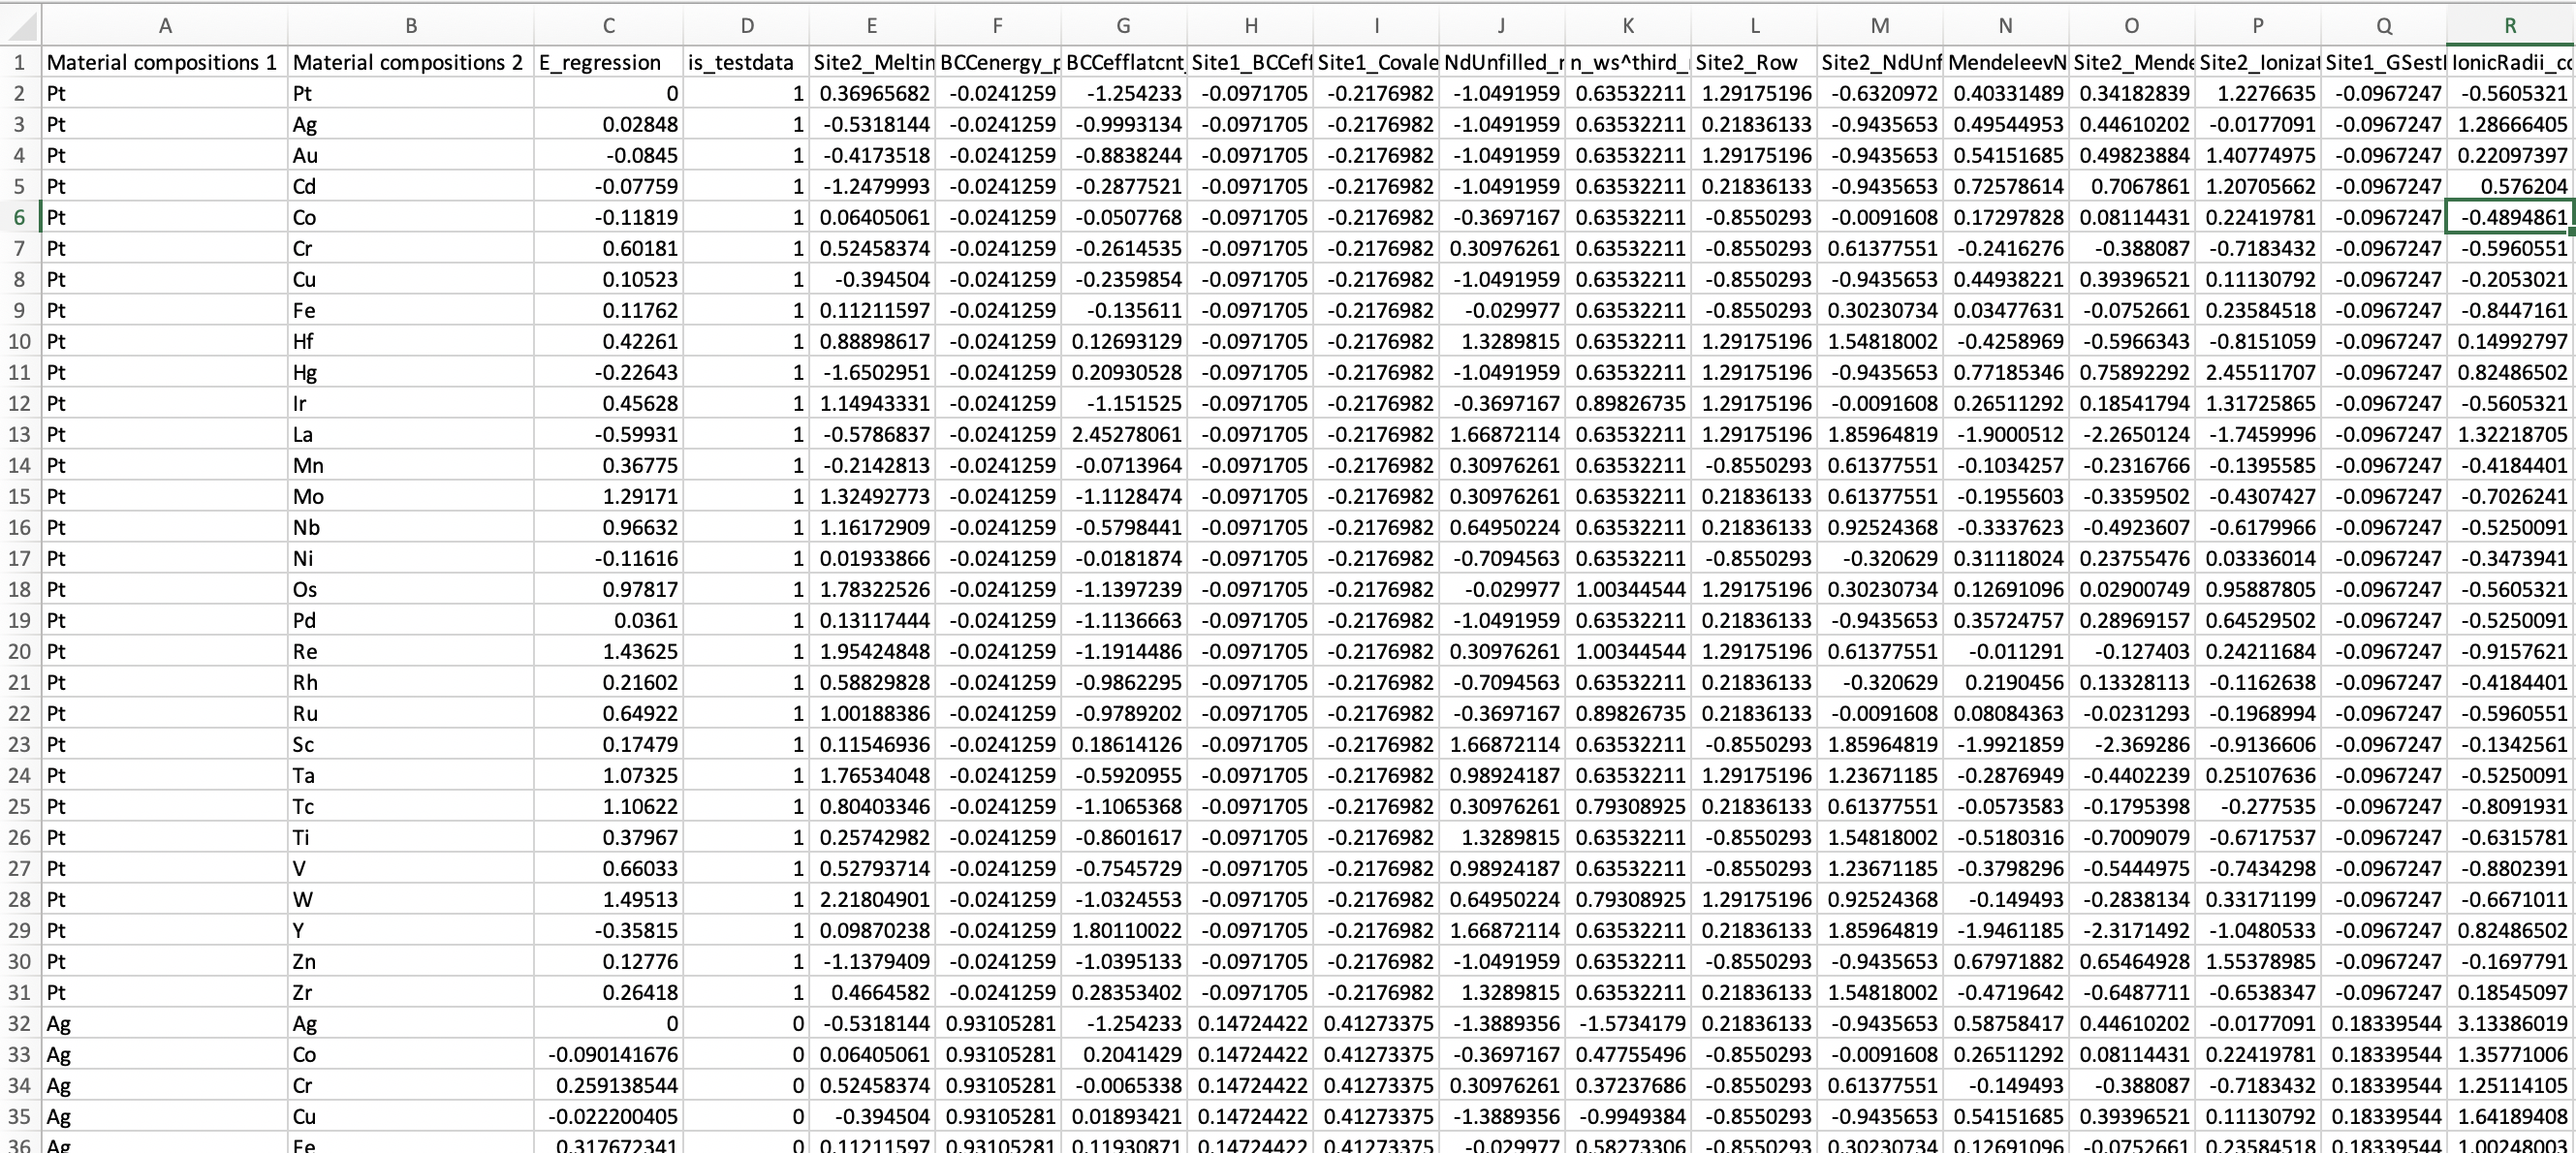

In [4]:
target = 'E_regression'

extra_columns = ['Material compositions 1', 'Material compositions 2', 'is_testdata']

# testdata_columns: column names denoting left-out data to evaluate using best
#   model from CV tests. This is manual way to leave out data. In our current case, 
#   the column called "is_testdata" denotes which points will be left out
#   as_frame: whether to return data as dataframe. Want this to be true.
d = LocalDatasets(file_path=data_path+'/diffusion_data_leaveoutPt.xlsx', 
                  target=target, 
                  extra_columns=extra_columns, 
                  group_column='Material compositions 1',
                  testdata_columns=['is_testdata'],
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Let's assign each data object to its respective name
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

We have one left out data set in this example, so X_testdata is a list with an array containing
the indices of the left out data, which will be automatically used in our data splitter. We
see there are 30 left out data points, which correspond to the number of points where Pt is the
host element

In [5]:
X_testdata[0].shape

(30,)

We are going to primarily be evaluating Kernel ridge models in this tutorial. Let's build 
and run a Kernel ridge model using random 5-fold cross validation, where we also specify
our X_testdata in the splitter evaluate() method (as the leaveout_inds parameter),
so that it knows to predict the values of the left out data.

In [6]:
model_krr = SklearnModel(model='KernelRidge', kernel='rbf')
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_krr],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

When we examine our output directory, we see that now there is a new "split_outer_0"
directory, and within that directory reside the individual split directories we have
seen from previous tutorials. There is one split outer directory because there was one
set of left-out data. For this split_outer_0 directory, the Pt host data are left out, and
random 5-fold CV is performed on the remaining data to assess model performance

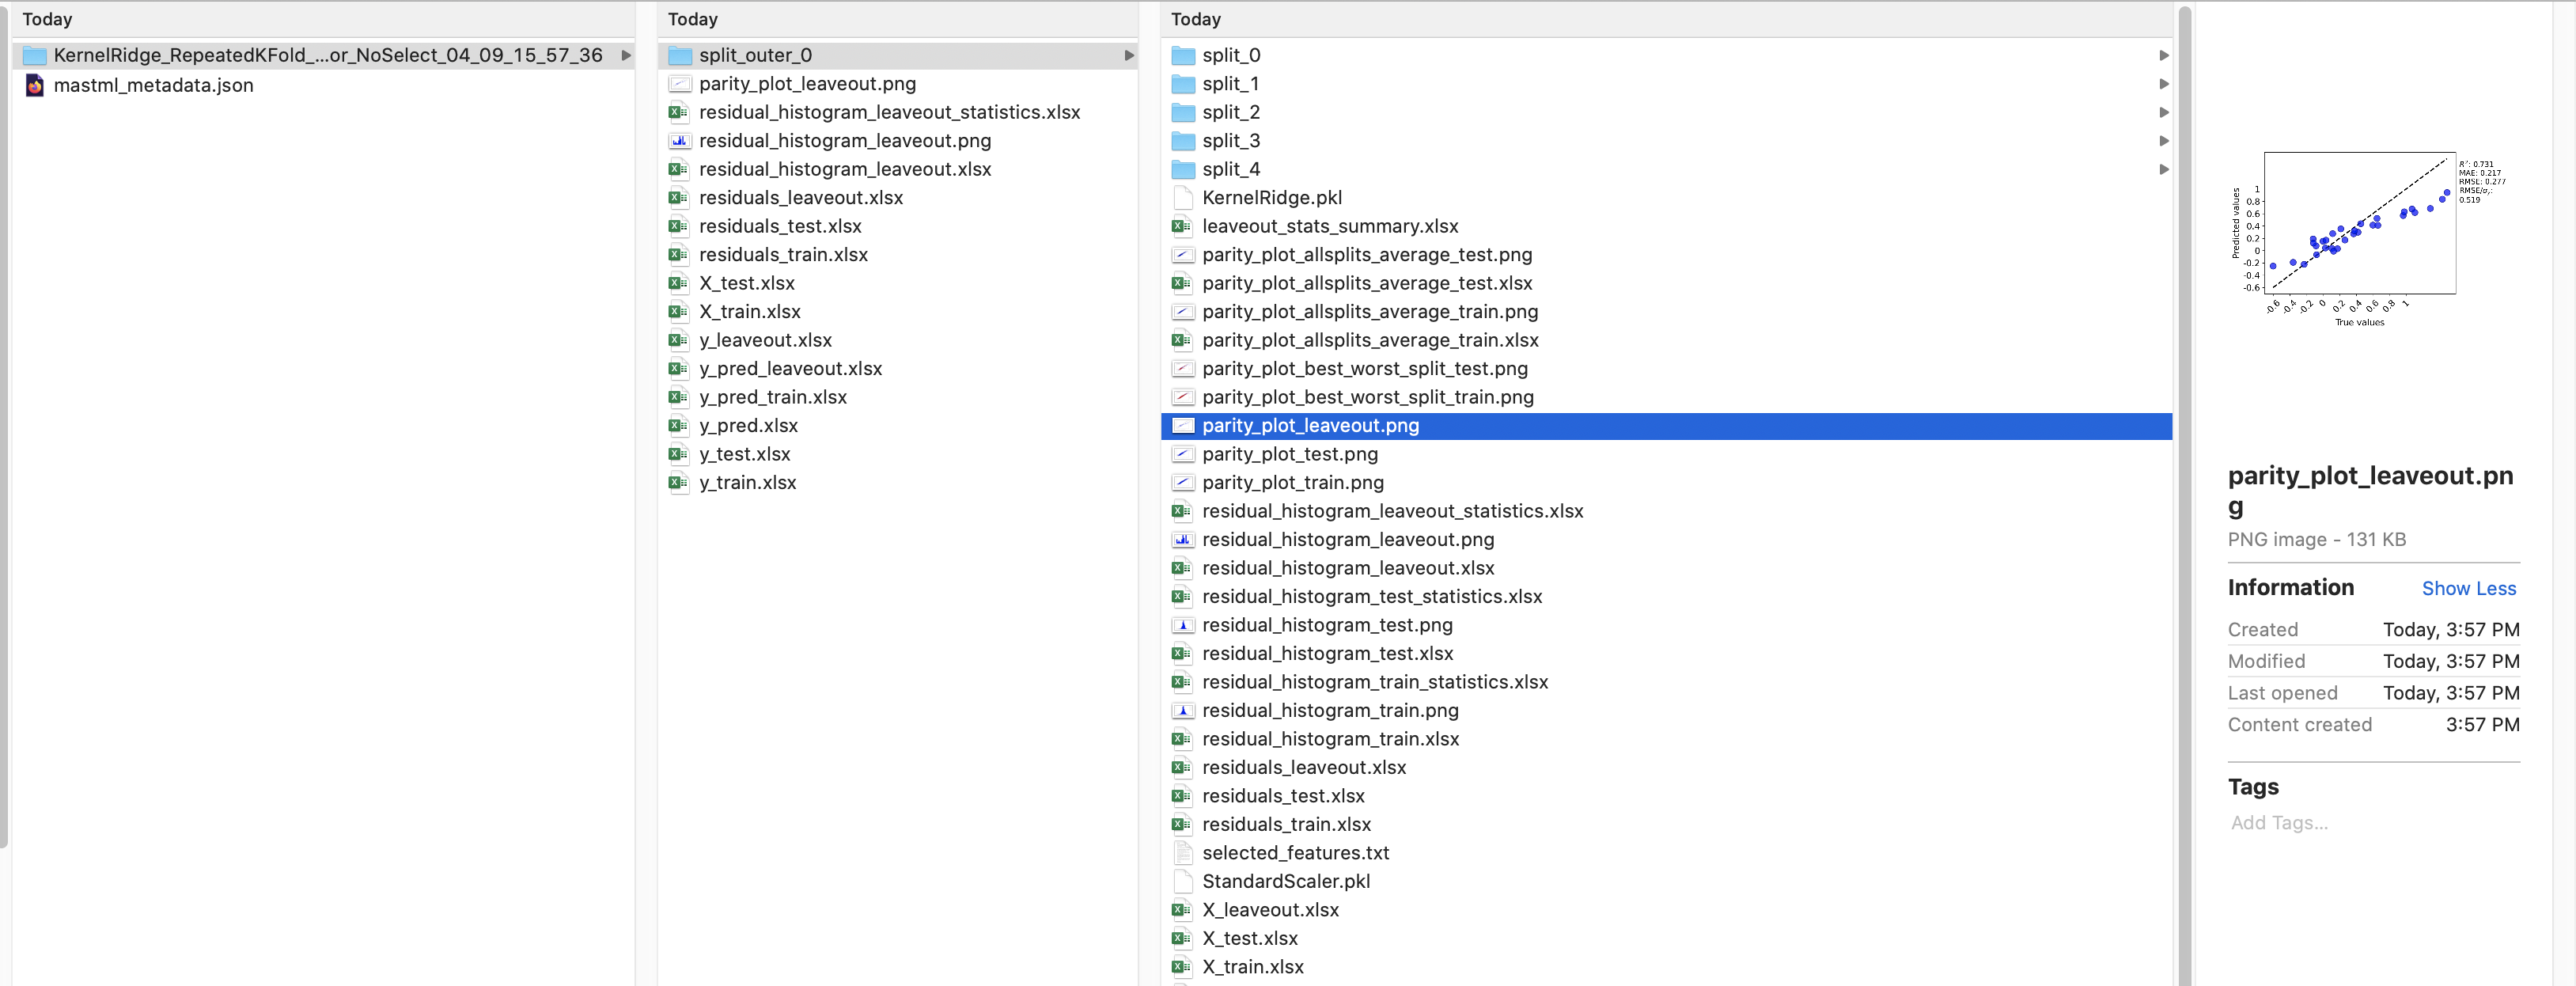

How did the model do with predicting the Pt data? 

### Pt left out data parity plot:
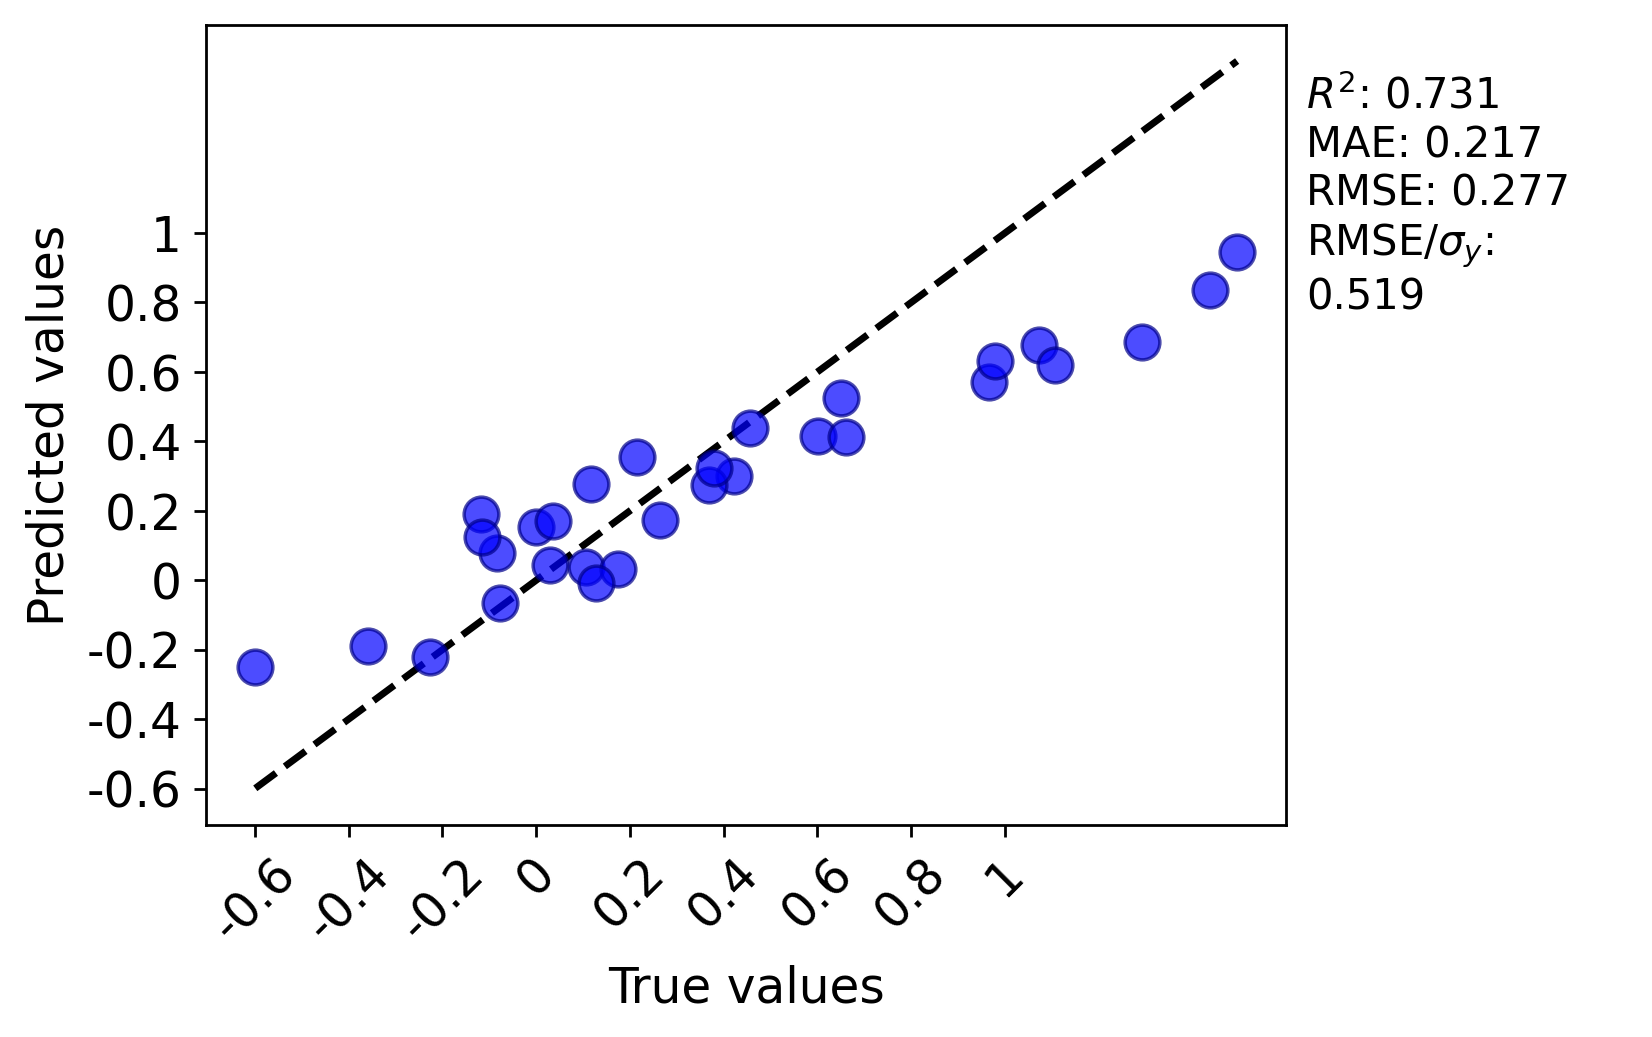

### Parity plot of test data in random CV:
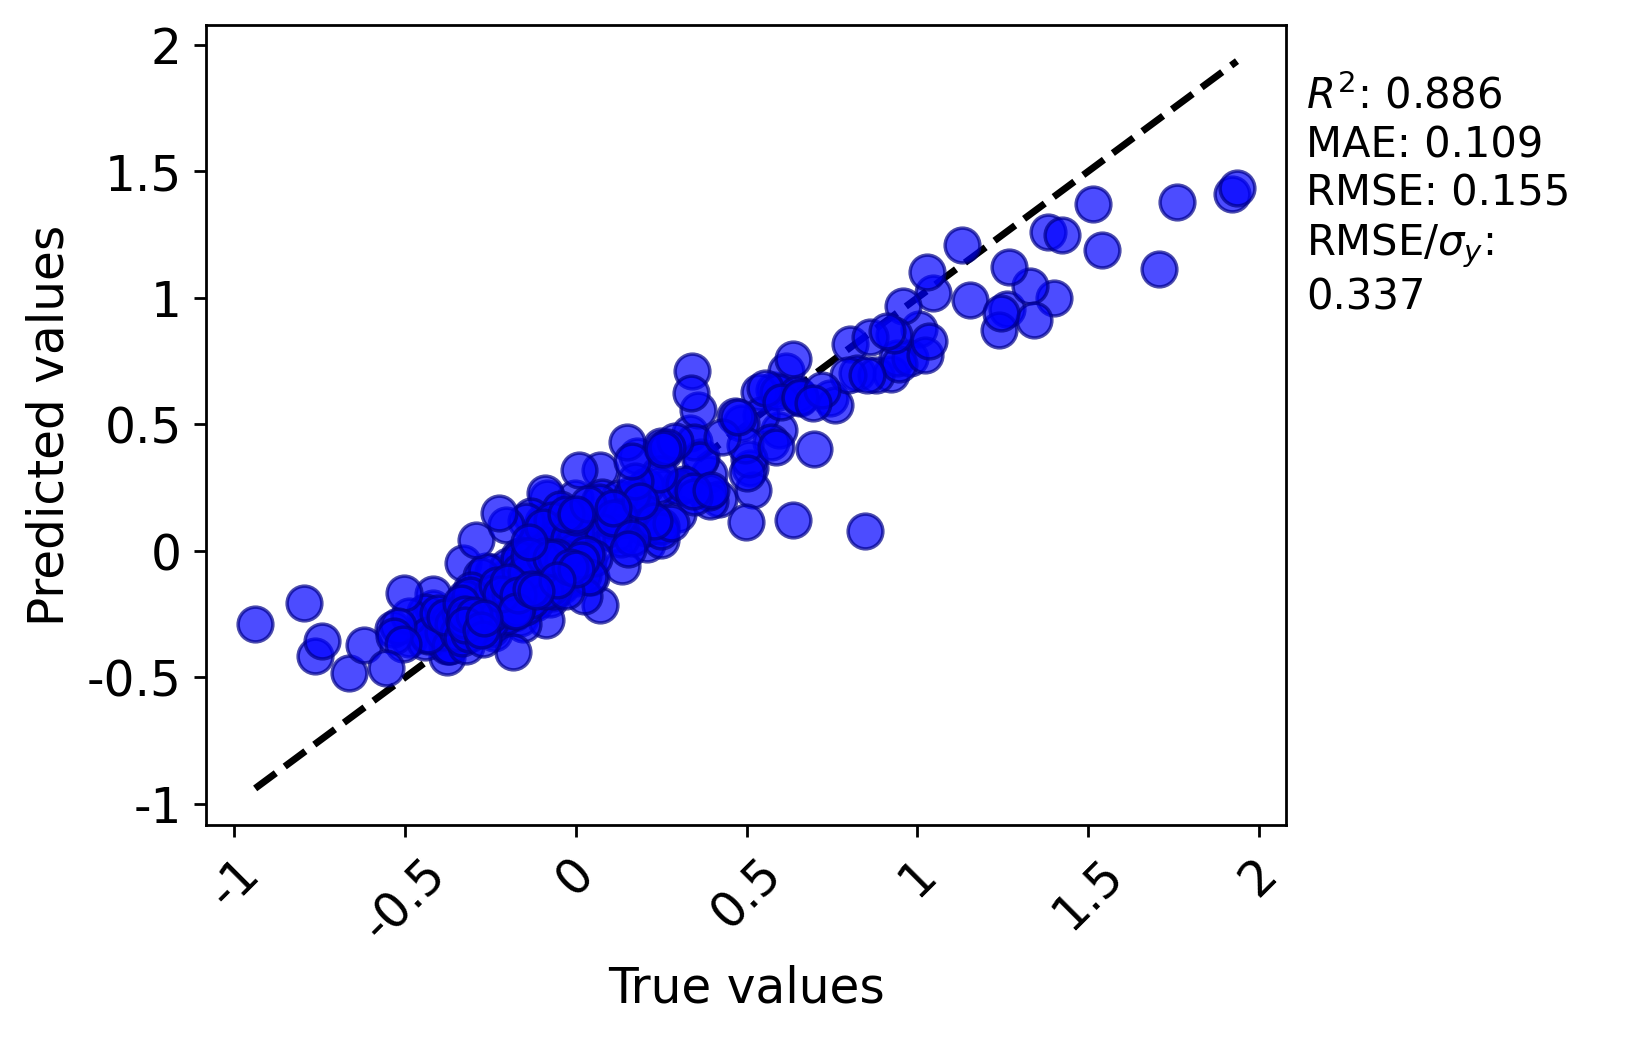


My model got an RMSE of 0.277 eV, while the 5-fold RMSE on the remaining data was 0.155 eV. The prediction of Pt was higher than 
this value because random 5-fold CV is an overly optimistic predictor of model performance
when predicting the values of unseen data from a new group!

## Task 3: Perform nested cross validation to assess model performance on unseen data <a name="task3"></a>

Instead of just manually specifying which data should be left-out data, we can have MAST-ML
do this automatically via nested cross validation. Any data splitter can be used to perform
nested cross validation. Here, we will perform nested CV with our kernel ridge method using
both 5-fold and leave out group cross validation. Then, we can compare how our previous result
of predicting on Pt compares to the left-out data RMSE values from 5-fold and leave out group
tests. 

This time, we are not specifying the leaveout_inds parameter. To use nested CV,
we set nested_CV=True in the evaluate method. The data splitter method is repeated
for each nesting level, so here we are doing 1 cycle of 5-fold CV. That means that there
will be 5 level 1 splits, and 5 level 2 splits for each of the level 1 split, making for 
a total of 5*5 = 25 splits. 

In [7]:
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_krr],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  verbosity=3)

For leave out group, recall we need to set the groups parameter in the evaluate method.
When doing nested CV with leave out group, the total number of splits will be n_groups*n_groups,
so in our case that is 125 splits (be patient- this run will take about 10 minutes or so). Here, we
turn the verbosity down to 1, which will only make plots for the left out data series. This will speed
the run up a bit!

In [ ]:
splitter = SklearnDataSplitter(splitter='LeaveOneGroupOut')
splitter.evaluate(X=X,
                  y=y, 
                  groups=groups,
                  models=[model_krr],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  verbosity=1)

### Nested random cross validation:
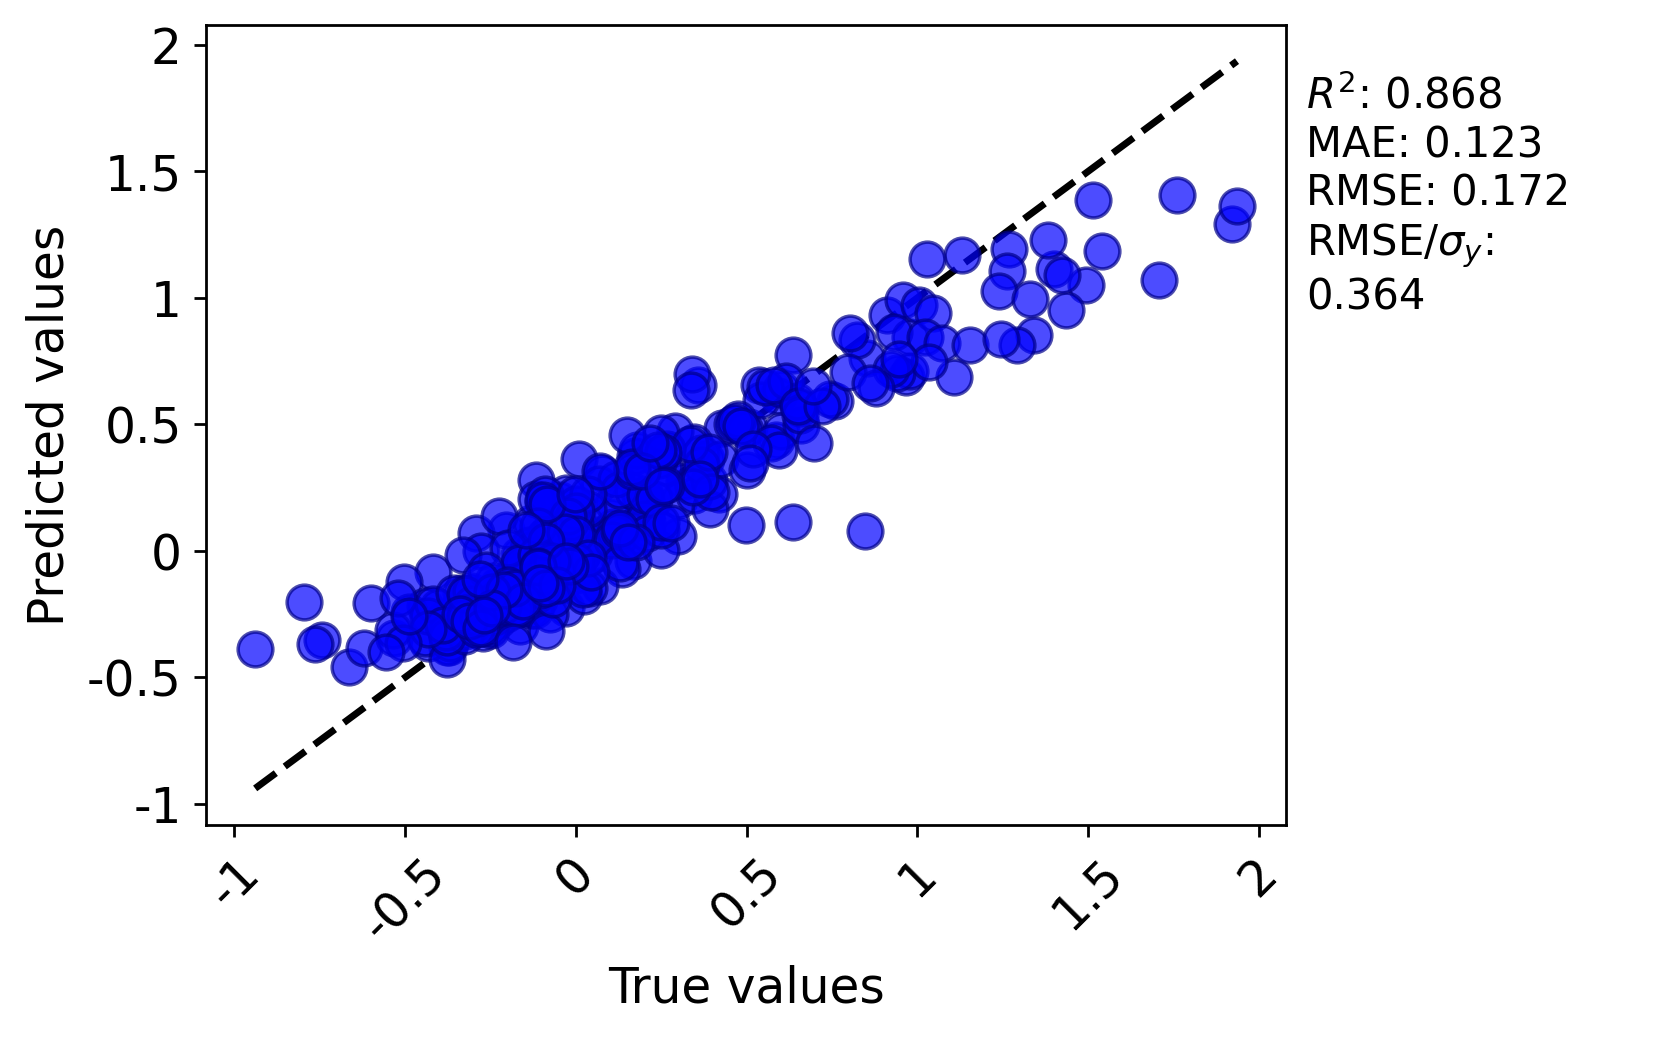

### Nested leave out group cross validation:
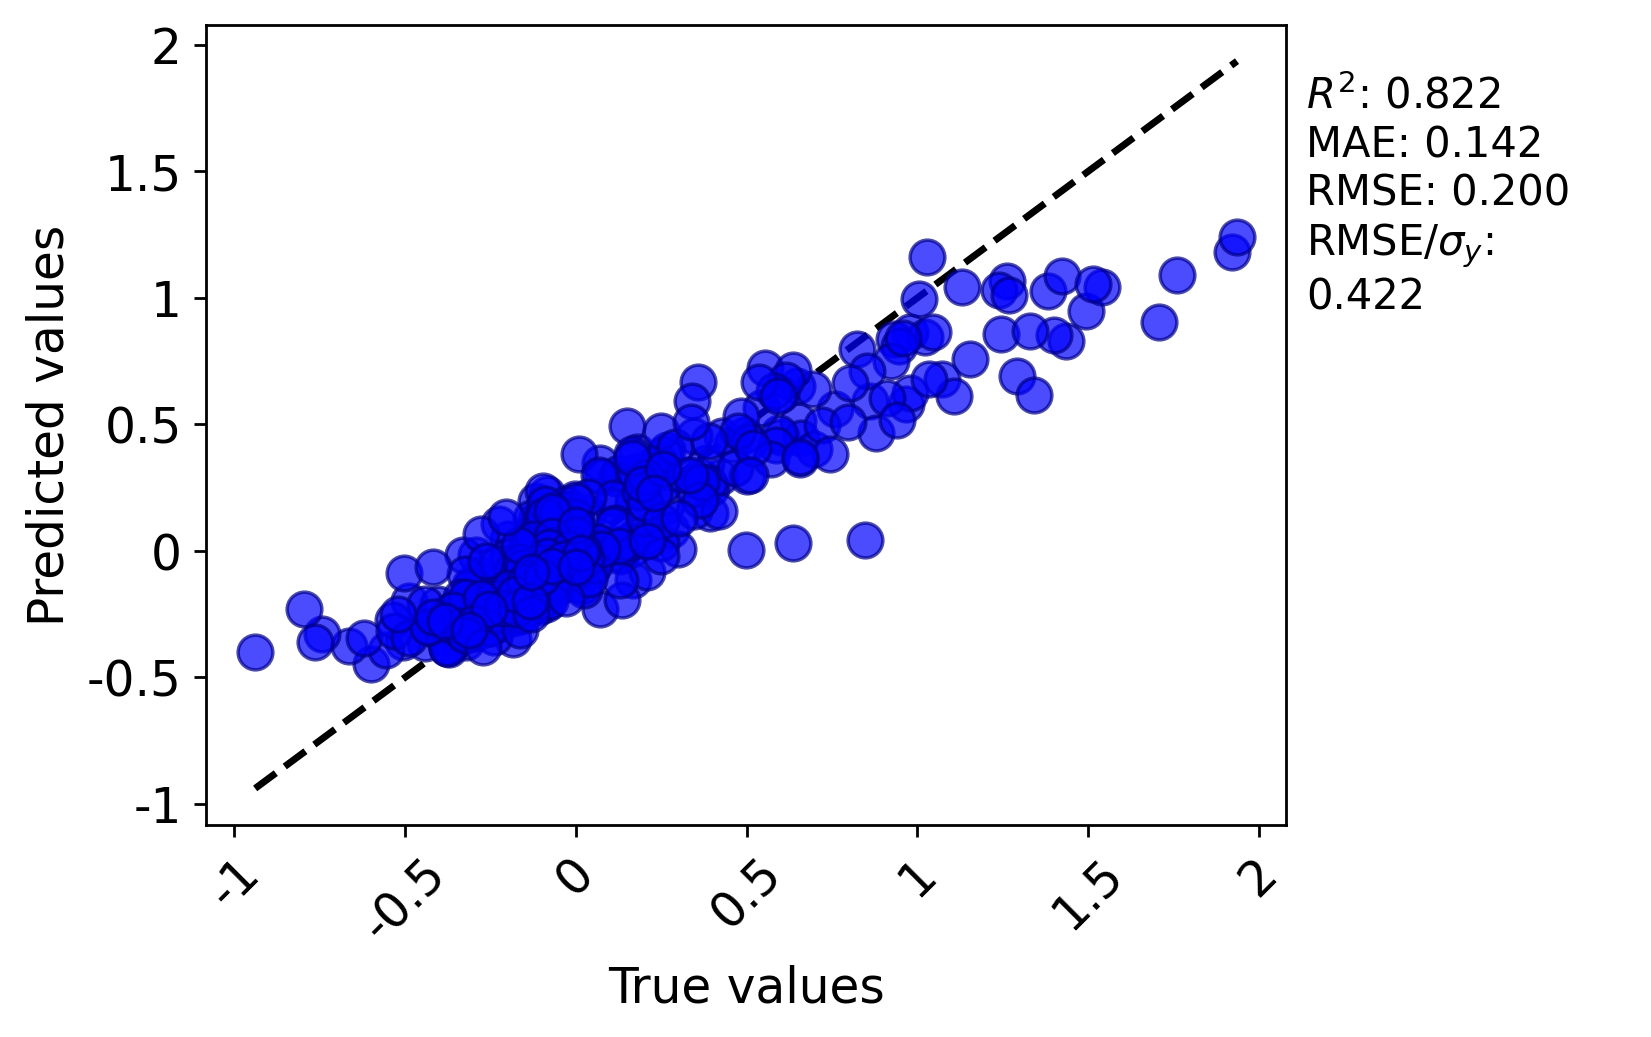

My previous result of leave out Pt RMSE was 0.277 eV. The nested CV left out data RMSEs are
0.172 eV for 5-fold and 0.200 eV for leave out group. It's evident that the leave out group
test is more closely aligned with the scale of error one should expect by predicting on a 
new group, and the prediction of Pt seems to be a rather difficult one, considering its 
error is even higher than the nested leave out group score. This is consistent with what
we saw in Tutorial 4, where the Pt RMSE was among the highest of all the groups from the
RMSE vs group plot.

## Task 4: Optimize the hyperparameters of our models to create the best model <a name="task4"></a>

Let's go back to our dataset from the first task where we leave out Pt and
include hyperparameter optimization for our kernel ridge model. To keep the runs reasonably fast, 
we are only going to optimize the alpha parameter in Kernel ridge, which is the regularization strength.
This optimization will be done for each train/test split in the random
5-fold cross validation stage. Then, the best model will be selected and used to predict the
left out Pt data. 

The parameters for hyperparameter optimization routines have a defined structure. The parameter
names need to be separated by semicolons (see below commented part for designating alpha, gamma,
and kernel type). The parameter values are also delimited by semicolons (one set per parameter).
For designating the grid of values to explore, the first number is the lower bound, the second
number is the upper bound, the third number is grid density, and the fourth value is "lin" or 
"log" to denote linear or logarithmic scale, respectively. The final value is the data type of the
parameter.

In [8]:
model_krr = SklearnModel(model='KernelRidge', kernel='rbf')
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

hyperopt = GridSearch(param_names='alpha',
                     param_values='-5 5 100 log float',
                     scoring='root_mean_squared_error')

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_krr],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  hyperopts=[hyperopt],
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

Below is an example of optimizing three parameters in the Kernel ridge model. We don't run it here
because it will take a long time

hyperopt = GridSearch(param_names='alpha ; gamma ; kernel',
        param_values='-5 5 100 log float ; -5 5 100 log float ; linear rbf sigmoid str',
        scoring='root_mean_squared_error')



MAST-ML performs hyperparameter optimization for each train/test split, yielding an optimized model
for each training set. Within the split directory, a spreadsheet containing the best model parameters
and the cross validation scores for each set of parameters are saved:

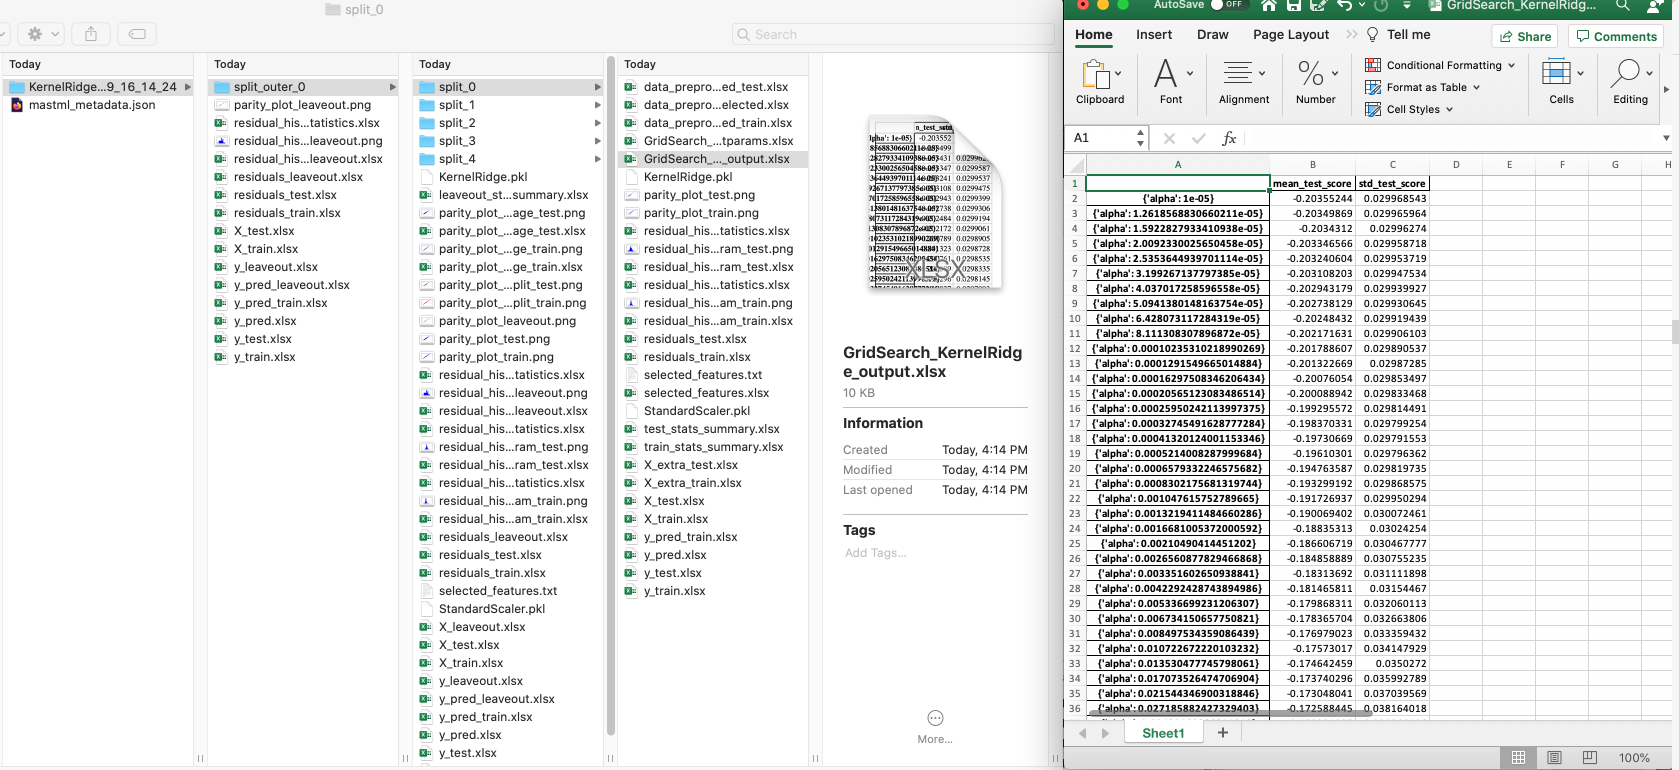

How does this model perform on the Pt data compared to the one we ran above? When just using the
non-optimized Kernel ridge model, I got an RMSE of 0.277 eV. 

### Pt left out data parity plot (not optimized):
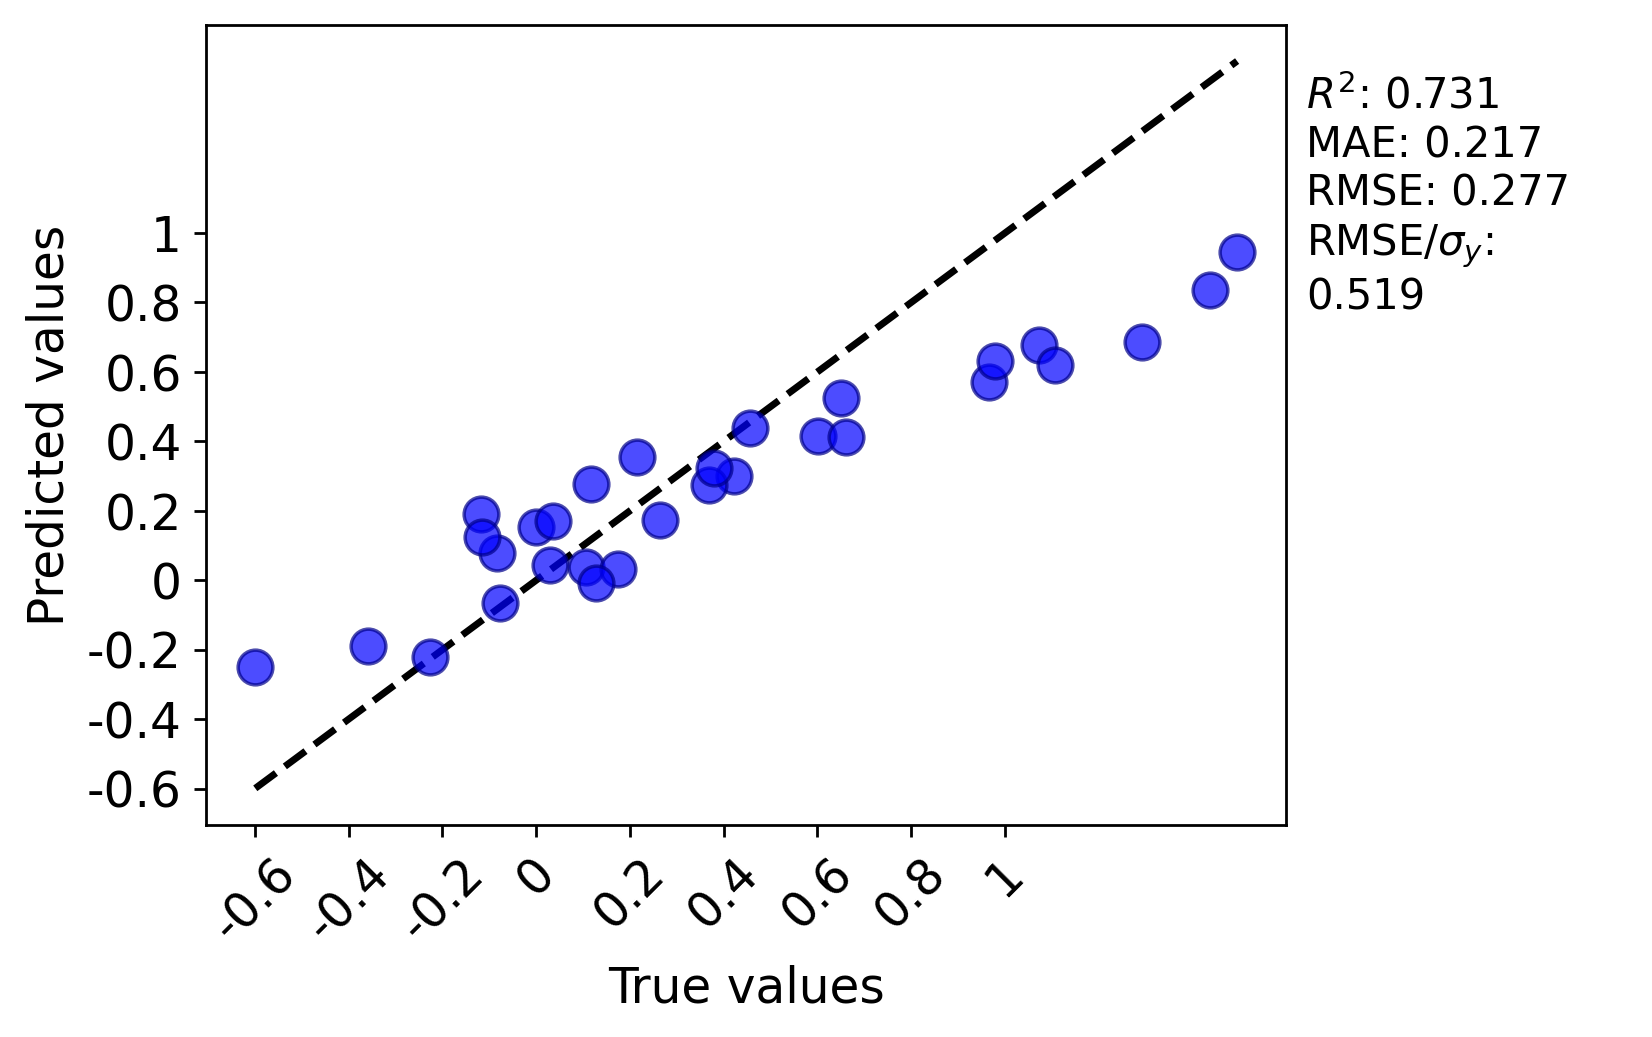

### Pt left out data parity plot (optimized):
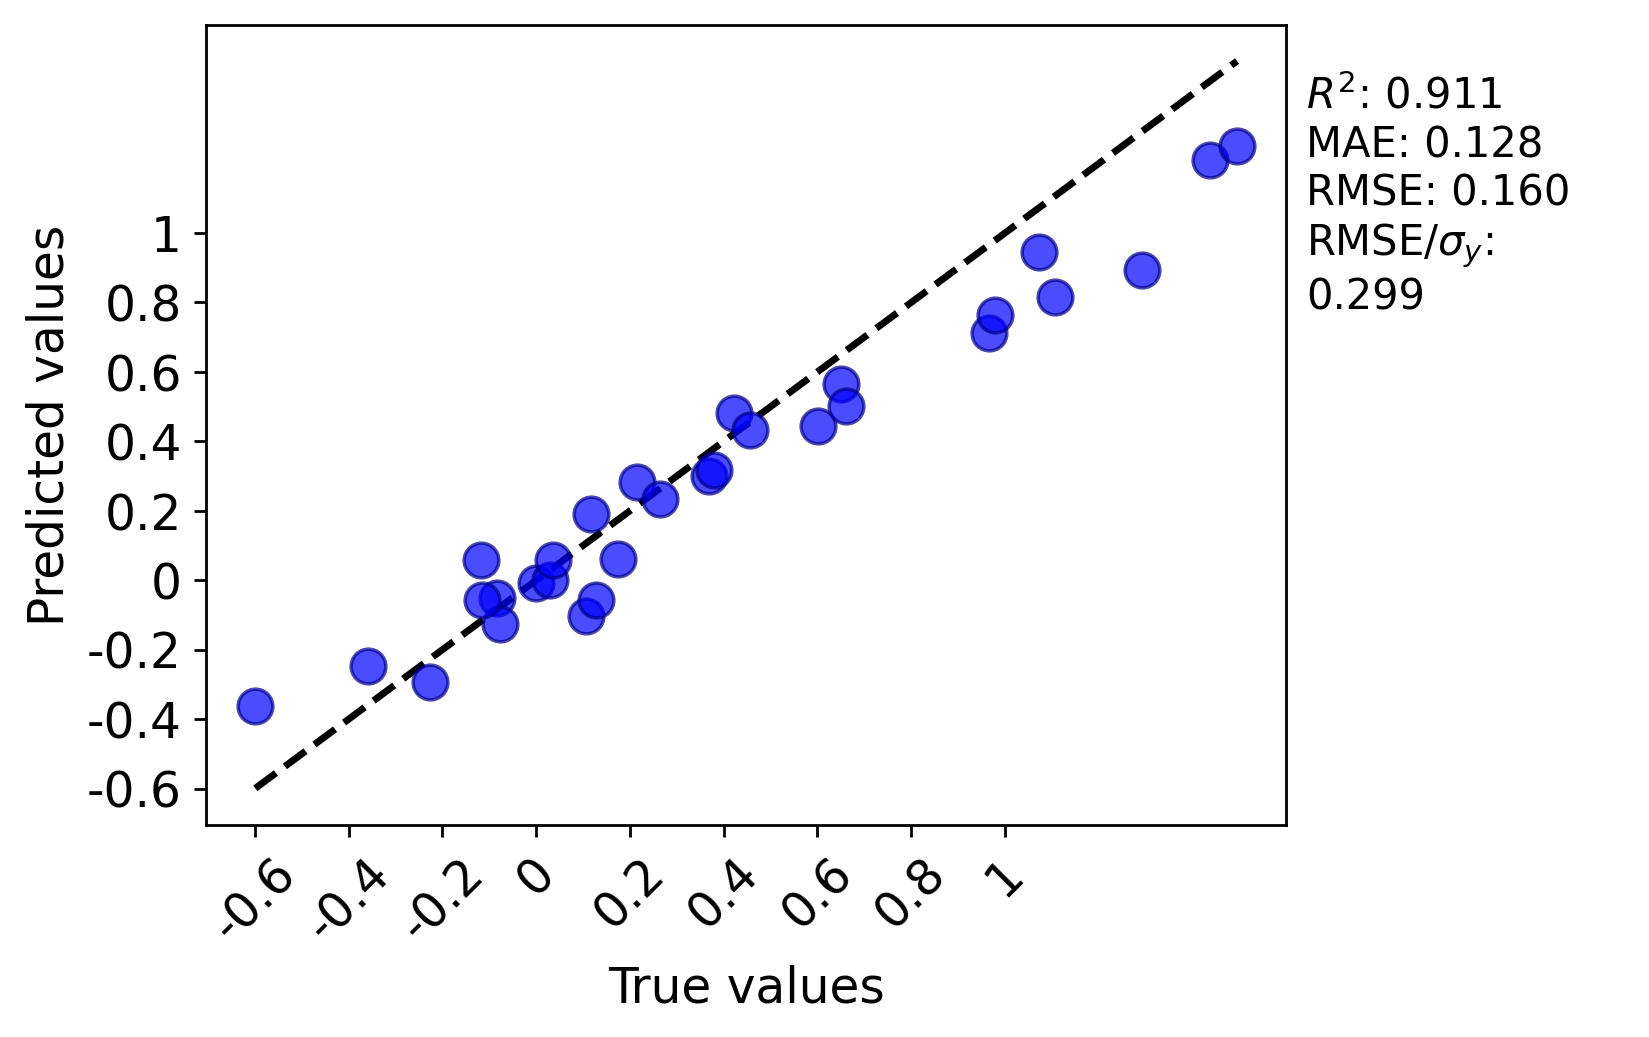

After optimizing just the alpha parameter, the RMSE on the Pt data has dropped to just 0.160 eV!

Let's try another form of hyperparameter optimization. Instead of performing
a grid search, we are going to do a randomized search. We will search
over two variables this time: alpha and gamma. Instead of specifying a range
of values to examine, the param_values need to be probability distributions
from the scipy.stats module. Here, we have just used uniform distributions.
One could also specify a normal distribution, exponential or sinusoidal distribution, etc.
The n_iter tag affects convergence and needs to be high enough such that the optimal
parameter values are found for a given split.

In [9]:
hyperopt = RandomizedSearch(param_names='alpha ; gamma',
                            param_values='uniform ; uniform',
                            scoring='root_mean_squared_error',
                            n_iter=100)

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_krr],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  hyperopts=[hyperopt],
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

The following is one more example of performing a grid search, this time using an
MLPRegressor model. This model is a bit unique in that one of its key inputs
is a tuple, not just a string or number. There is a designated format for handling
a grid search of a set of tuples, which is shown below. In param_values, we have
5 different neural network architectures. The grid search will try each one and
assess which is best.

In [ ]:
model_nn = SklearnModel(model='MLPRegressor', hidden_layer_sizes=(20,))
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

hyperopt = GridSearch(param_names='hidden_layer_sizes',
                     param_values='(20,) (20,10) (10,5) (10,) (20,10,5) tup',
                     scoring='root_mean_squared_error')

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_nn],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  hyperopts=[hyperopt],
                  plots=['Scatter', 'Histogram'],
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

With everything we've covered here, you could combine nested CV with the hyperparameter optimization
to obtain a more realistic best-case fit model for both the random CV and leave out group CV
tests. This exercise is quite time consuming and will be part of a designated tutorial notebook
which takes the user from the end-to-end process of building, evaluating and using ML models

You've now completed your fifth MAST-ML tutorial notebook! Now that you're more familiar with performing detailed
model evaluation with nested cross validation and creating optimized models, it is time to move to one of the final
tutorials in this series, and a subject of great importance when evaluating the efficacy of ML models: predictions
of model errors, domains, and uncertainty quantification (UQ).

The next example in this notebook series is titled MASTML_Tutorial_6_ErrorAnalysis_UncertaintyQuantification.ipynb, 
and will guide you through the process assessing the true and predicted errors of some models on a select dataset
and detail methods to recalibrate the model uncertainty estimates to more accurately reflect the true model errors.